<h1>预测工资</h1>

既然我们有了拉勾的数据，我们可以用它来耍耍，预测一下工资。


<h3>1、对工资进行转换</h3>

在这之前先导入模块并读入文件，不仅有训练数据文件，还有一组自拟的测试数据文件。

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

train_file = "analyst.csv"
test_file = "test.csv"
# 读取文件获得数据
train_data = pd.read_csv(train_file, encoding="gbk")
train_data = train_data.drop('ID', axis=1)

test_data = pd.read_csv(test_file, encoding="gbk")
train_data.shape, test_data.shape
# data['薪资'].value_counts()

((450, 3), (24, 2))

为了更好地进行分析，我们要对薪资做一个预处理。由于其分布比较散乱，很多值的个数只有1。为了不造成过大的误差，根据其分布情况，可以将它分成【5k 以下、5k-10k、10k-20k、20k-30k、30k-40k、40k 以上】，为了更加方便我们分析，取每个薪资范围的中位数，并划分到我们指定的范围内。

In [2]:
salarys = train_data['薪资'].unique()     # 获取到薪资的不同值
for salary in salarys:
    # 根据'-'进行分割并去掉'k',分别将两端的值转换成整数
    min_sa = int(salary.split('-')[0][:-1])
    max_sa = int(salary.split('-')[1][:-1])
    # 求中位数
    median_sa = (min_sa + max_sa) / 2
    # 判断其值并划分到指定范围
    if median_sa < 5:
        train_data.replace(salary, '5k以下', inplace=True)
    elif median_sa >= 5 and median_sa < 10:
        train_data.replace(salary, '5k-10k', inplace=True)
    elif median_sa >= 10 and median_sa < 20:
        train_data.replace(salary, '10k-20k', inplace=True)
    elif median_sa >= 20 and median_sa < 30:
        train_data.replace(salary, '20k-30k', inplace=True)
    elif median_sa >= 30 and median_sa < 40:
        train_data.replace(salary, '30k-40k', inplace=True)
    else:
        train_data.replace(salary, '40k以上', inplace=True)
train_data.head()

,学历要求,工作经验,薪资
0,大专,3-5年,10k-20k
1,本科,3-5年,10k-20k
2,本科,不限,5k-10k
3,本科,5-10年,30k-40k
4,本科,3-5年,30k-40k


处理完成后，我们可以将“薪资”单独提取出来当作训练集的 label。

In [3]:
y_train = train_data.pop('薪资').values

<h3>2、对变量进行转换</h3>

<h4>把category的变量转变成numerical表达式</h4>

由于变量都不是numerical变量，在训练的时候计算机没办法识别，因此要对它们进行转换。

当我们用numerical来表达categorical的时候，要注意，数字本身有大小的含义，所以乱用数字会给之后的模型学习带来麻烦。于是我们可以用One-Hot的方法来表达category。

pandas自带的get_dummies方法，可以一键做到One-Hot。

这里按我的理解解释一下One-Hot：比如说data['学历要求']有'大专', '本科', '硕士', '不限'。但data['学历要求']=='本科'，则他可以用字典表示成这样{'大专': 0, '本科':1, '硕士':0, '不限':0}，用向量表示为[0, 1, 0, 0]

在此之前，将测试集和训练集组合起来一起处理，稍微方便一点。

In [4]:
data = pd.concat((train_data, test_data), axis=0)
data.shape

(474, 2)

In [5]:
dummied_data = pd.get_dummies(data)
dummied_data.head()

,学历要求_不限,学历要求_大专,学历要求_本科,学历要求_硕士,工作经验_1-3年,工作经验_1年以下,工作经验_3-5年,工作经验_5-10年,工作经验_不限,工作经验_应届毕业生
0,0,1,0,0,0,0,1,0,0,0
1,0,0,1,0,0,0,1,0,0,0
2,0,0,1,0,0,0,0,0,1,0
3,0,0,1,0,0,0,0,1,0,0
4,0,0,1,0,0,0,1,0,0,0


上次可视化分析的时候就已经知道数据集中不存在缺失值了，为了走一下流程并确保正确性，再次看一下是否有缺失值。

In [6]:
dummied_data.isnull().sum().sort_values(ascending=False).head(10)

工作经验_应届毕业生    0
工作经验_不限       0
工作经验_5-10年    0
工作经验_3-5年     0
工作经验_1年以下     0
工作经验_1-3年     0
学历要求_硕士       0
学历要求_本科       0
学历要求_大专       0
学历要求_不限       0
dtype: int64

OK，很好，没有缺失值。这些值比较简单，不需要做那么多工作。

<h2>3、建立模型</h2>

<h4>DecisionTree</h4>

In [7]:
X_train = dummied_data[:train_data.shape[0]].values
X_test = dummied_data[-test_data.shape[0]:].values
len(X_train), len(X_test)

(450, 24)

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

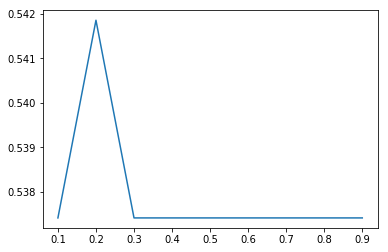

In [9]:
features_scores = []
max_features = [.1, .2, .3, .4, .5, .6, .7, .8, .9]
for max_feature in max_features:
    clf = DecisionTreeClassifier(max_features=max_feature)
    features_score = cross_val_score(clf, X_train, y_train, cv=5)
    features_scores.append(np.mean(features_score))
plt.plot(max_features, features_scores)

可见当 max_features = 0.2 时达到最大，大概有0.5418


In [10]:
dtc = DecisionTreeClassifier(max_features=0.2)

<h3>ensemble（集成算法）</h3>

集成学习简单理解就是指采用多个分类器对数据集进行预测，从而提高整体分类器的泛化能力。
    
<h4>AdaBoostClassifier</h4>

adaptive boosting: 通过改变训练样本的权值，学习多个分类器，并将这些分类器进行线性组合，提高泛化性能。

In [11]:
from sklearn.ensemble import AdaBoostClassifier

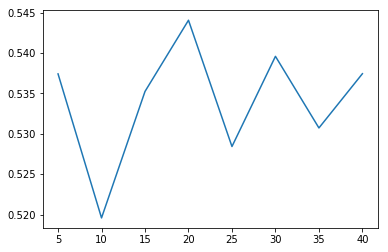

In [12]:
n_scores = []
estimator_nums = [5, 10, 15, 20, 25, 30, 35, 40]
for estimator_num in estimator_nums:
    clf = AdaBoostClassifier(n_estimators=estimator_num, base_estimator=dtc)
    n_score = cross_val_score(clf, X_train, y_train, cv=5)
    n_scores.append(np.mean(n_score))
plt.plot(estimator_nums, n_scores)

当 estimators=20 的时候，score最高，大概有0.544，虽然跟单个决策树的 score 的值相差不大，但总体还是有所提升。

In [13]:
abc = AdaBoostClassifier(n_estimators=20)

In [14]:
abc.fit(X_train, y_train)
dtc.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=0.2, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [15]:
y_dtc = dtc.predict(X_test)
y_abc = abc.predict(X_test)

In [16]:
test_data['薪资(单个决策树)'] = y_dtc
test_data['薪资(boosting)'] = y_abc
test_data

,学历要求,工作经验,薪资(单个决策树),薪资(boosting)
0,本科,1-3年,10k-20k,10k-20k
1,本科,3-5年,20k-30k,20k-30k
2,本科,5-10年,30k-40k,20k-30k
3,本科,应届毕业生,10k-20k,10k-20k
4,本科,不限,10k-20k,10k-20k
5,本科,1年以下,10k-20k,10k-20k
6,大专,1-3年,5k-10k,5k-10k
7,大专,3-5年,10k-20k,10k-20k
8,大专,5-10年,30k-40k,10k-20k
9,大专,应届毕业生,10k-20k,5k-10k
